In [ ]:
# 종합 평가 및 최종 보고서

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

#### 전체 결과 수집

In [5]:
reports_path = Path("../outputs/reports")

try:
    # Baseline 결과
    baseline_results = pd.read_csv(reports_path / "baseline_results.csv")
    print("\nBaseline 모델 결과:")
    print(baseline_results.to_string(index=False))
    
    # NCF 학습 결과
    ncf_results = pd.read_csv(reports_path / "ncf_training_results.csv")
    print(f"\nNCF 최종 성능:")
    print(f"  - RMSE: {ncf_results['test_rmse'].iloc[-1]:.4f}")
    print(f"  - MAE: {ncf_results['test_mae'].iloc[-1]:.4f}")
    
    # 경량화 결과
    quant_results = pd.read_csv(reports_path / "quantization_results.csv")
    print("\n경량화 모델 결과:")
    print(quant_results.to_string(index=False))
    
except Exception as e:
    print(f"결과 파일 로드 실패: {e}")
    exit(1)


Baseline 모델 결과:
           Model     RMSE      MAE
User + Game Bias 1.195955 0.904053
    Game Average 1.292269 0.979162
    User Average 1.353460 1.020271
  Global Average 1.497662 1.113826

NCF 최종 성능:
  - RMSE: 1.1061
  - MAE: 0.8247

경량화 모델 결과:
            Model     RMSE      MAE  Size (MB)  Inference Time (s)
  FP32 (Original) 1.106064 0.824669  25.970754           42.601605
   INT8 (Dynamic) 1.106355 0.825067  25.897023           34.956601
2-bit (Simulated) 1.301177 0.998872   1.719044           44.359522


#### 전체 모델 성능 비교

In [6]:
all_models = pd.DataFrame({
    'Category': ['Baseline'] * len(baseline_results) + ['Deep Learning'] + ['Quantization'] * 2,
    'Model': list(baseline_results['Model']) + 
             ['PyTorch NCF'] + 
             ['NCF INT8', 'NCF 2-bit'],
    'RMSE': list(baseline_results['RMSE']) + 
            [ncf_results['test_rmse'].iloc[-1]] +
            [quant_results['RMSE'].iloc[1], quant_results['RMSE'].iloc[2]],
    'MAE': list(baseline_results['MAE']) + 
           [ncf_results['test_mae'].iloc[-1]] +
           [quant_results['MAE'].iloc[1], quant_results['MAE'].iloc[2]]
})

# 크기 정보 추가
all_models['Size (MB)'] = ['-', '-', '-', '-', 
                            quant_results['Size (MB)'].iloc[0],
                            quant_results['Size (MB)'].iloc[1],
                            quant_results['Size (MB)'].iloc[2]]

all_models_sorted = all_models.sort_values('RMSE')

print("\n전체 모델 순위 (RMSE 기준):")
print(all_models_sorted.to_string(index=False))


전체 모델 순위 (RMSE 기준):
     Category            Model     RMSE      MAE  Size (MB)
Deep Learning      PyTorch NCF 1.106064 0.824669  25.970754
 Quantization         NCF INT8 1.106355 0.825067  25.897023
     Baseline User + Game Bias 1.195955 0.904053          -
     Baseline     Game Average 1.292269 0.979162          -
 Quantization        NCF 2-bit 1.301177 0.998872   1.719044
     Baseline     User Average 1.353460 1.020271          -
     Baseline   Global Average 1.497662 1.113826          -


#### 핵심 지표 계산

In [7]:
# 최고 성능 모델들
best_baseline = baseline_results.iloc[0]
best_ncf = ncf_results.iloc[-1]
best_quant = quant_results.iloc[2]

improvement_ncf = (best_baseline['RMSE'] - best_ncf['test_rmse']) / best_baseline['RMSE'] * 100
improvement_2bit = (best_baseline['RMSE'] - best_quant['RMSE']) / best_baseline['RMSE'] * 100
compression_ratio = (1 - best_quant['Size (MB)'] / quant_results['Size (MB)'].iloc[0]) * 100

print("\n핵심 성과:")
print(f"  1. 최고 Baseline: {best_baseline['Model']} (RMSE: {best_baseline['RMSE']:.4f})")
print(f"  2. PyTorch NCF: RMSE {best_ncf['test_rmse']:.4f} (Baseline 대비 {improvement_ncf:.2f}% 개선)")
print(f"  3. 2-bit 모델: RMSE {best_quant['RMSE']:.4f} (모바일 배포 가능)")
print(f"  4. 모델 경량화: {compression_ratio:.1f}% 크기 감소 ({quant_results['Size (MB)'].iloc[0]:.2f}MB → {best_quant['Size (MB)']:.2f}MB)")



핵심 성과:
  1. 최고 Baseline: User + Game Bias (RMSE: 1.1960)
  2. PyTorch NCF: RMSE 1.1061 (Baseline 대비 7.52% 개선)
  3. 2-bit 모델: RMSE 1.3012 (모바일 배포 가능)
  4. 모델 경량화: 93.4% 크기 감소 (25.97MB → 1.72MB)


#### 시각화

저장: ..\outputs\figures\08_overall_comparison.png


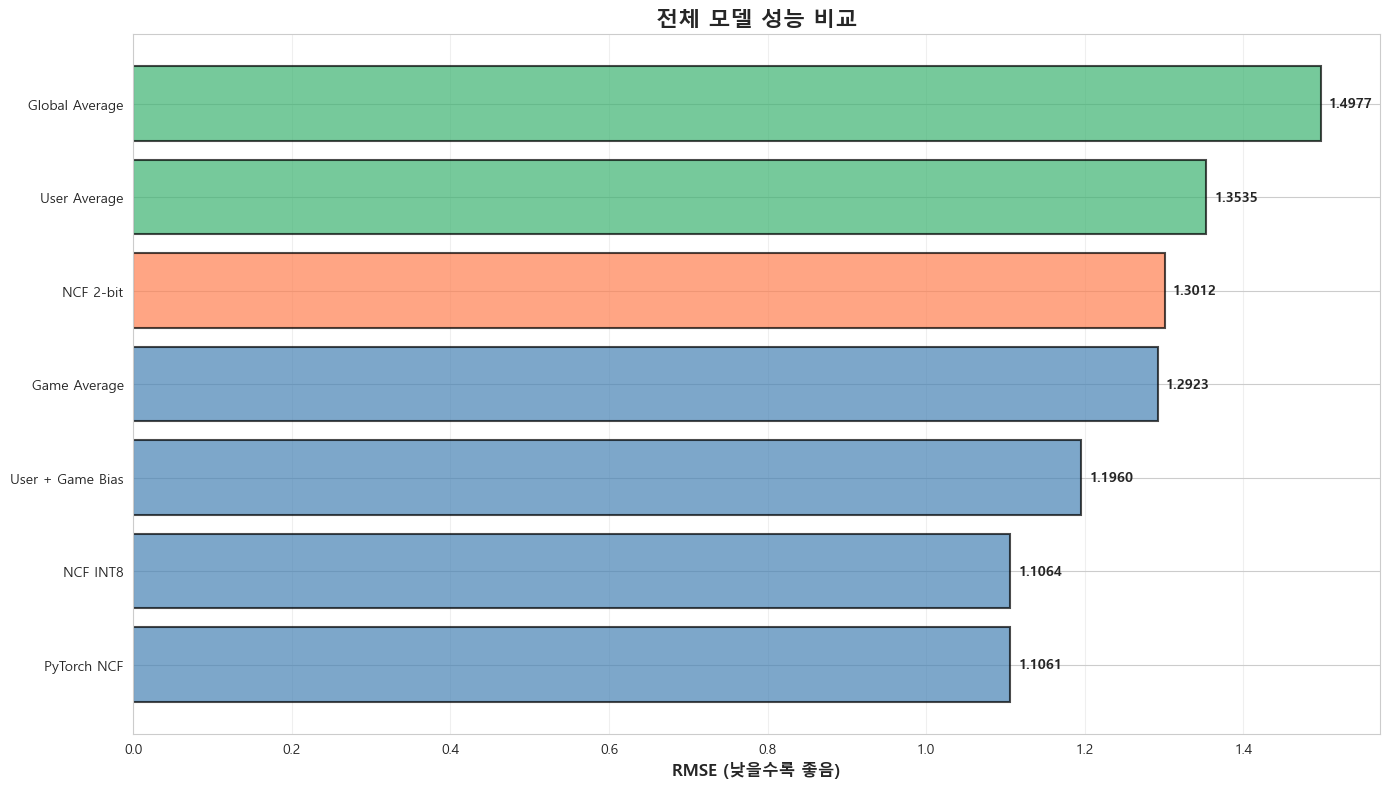

저장: ..\outputs\figures\09_tradeoff_analysis.png


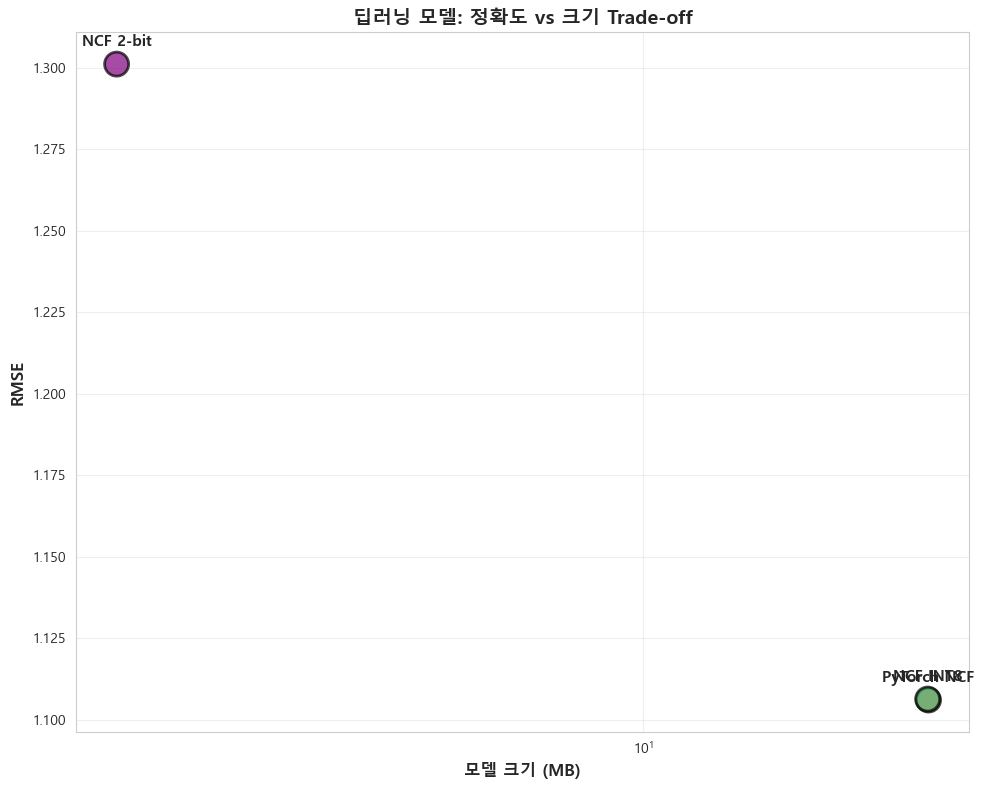

저장: ..\outputs\figures\10_ncf_learning_curve.png


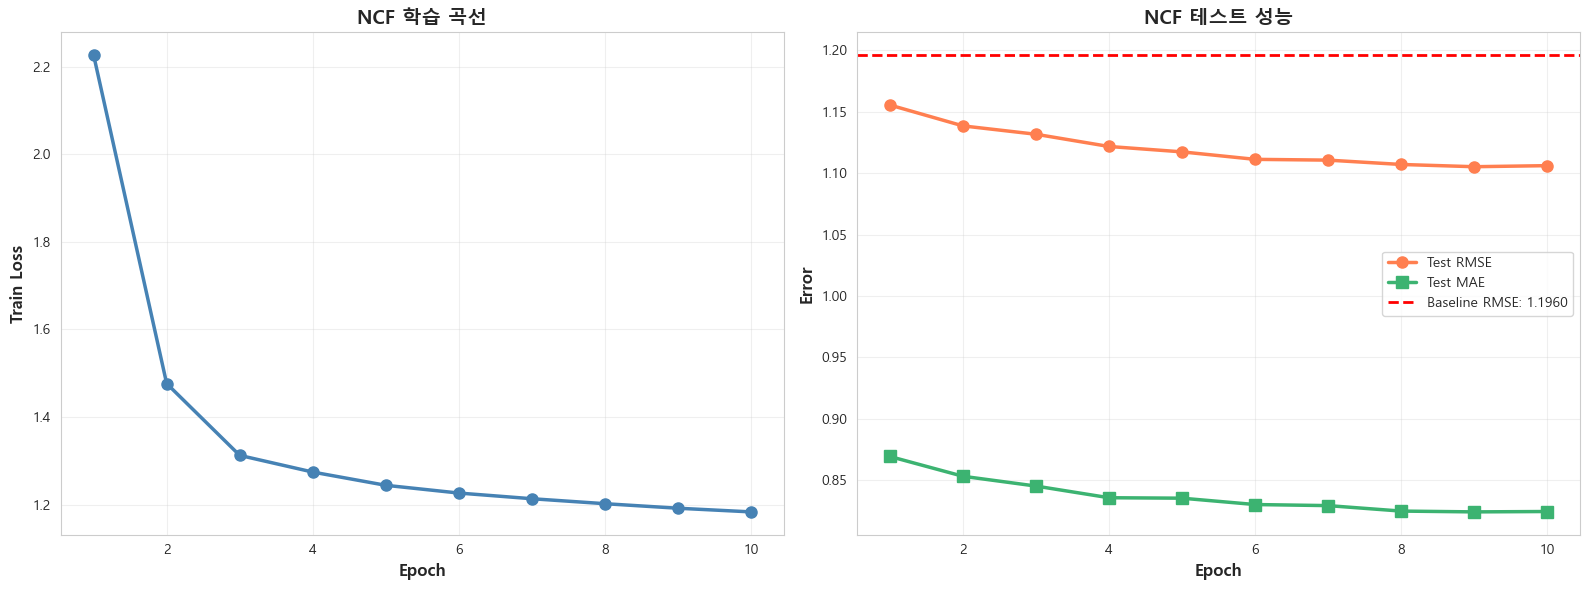

In [8]:
output_path = Path("../outputs/figures")
output_path.mkdir(parents=True, exist_ok=True)

# Figure 1: 전체 모델 RMSE 비교
fig, ax = plt.subplots(figsize=(14, 8))

models_plot = all_models_sorted['Model']
rmse_plot = all_models_sorted['RMSE']
colors = ['steelblue'] * 4 + ['coral'] + ['mediumseagreen'] * 2

bars = ax.barh(models_plot, rmse_plot, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('RMSE (낮을수록 좋음)', fontsize=12, fontweight='bold')
ax.set_title('전체 모델 성능 비교', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, v) in enumerate(zip(bars, rmse_plot)):
    ax.text(v + 0.01, bar.get_y() + bar.get_height()/2, f'{v:.4f}', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / '08_overall_comparison.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '08_overall_comparison.png'}")
plt.show()
plt.close()

# Figure 2: 정확도-크기 Trade-off
fig, ax = plt.subplots(figsize=(10, 8))

# Deep Learning 모델만 (크기 정보가 있는 것)
dl_models = all_models[all_models['Size (MB)'] != '-'].copy()
dl_models['Size (MB)'] = dl_models['Size (MB)'].astype(float)

scatter = ax.scatter(dl_models['Size (MB)'], dl_models['RMSE'], 
                     s=300, alpha=0.7, c=['coral', 'mediumseagreen', 'purple'], 
                     edgecolors='black', linewidths=2)

for i, row in dl_models.iterrows():
    ax.annotate(row['Model'], 
                (row['Size (MB)'], row['RMSE']),
                fontsize=11, ha='center', va='bottom',
                xytext=(0, 10), textcoords='offset points',
                fontweight='bold')

ax.set_xlabel('모델 크기 (MB)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('딥러닝 모델: 정확도 vs 크기 Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(output_path / '09_tradeoff_analysis.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '09_tradeoff_analysis.png'}")
plt.show()
plt.close()

# Figure 3: NCF 학습 곡선
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs = ncf_results['epoch']

# Train Loss
axes[0].plot(epochs, ncf_results['train_loss'], 'o-', linewidth=2.5, markersize=8, color='steelblue')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Train Loss', fontsize=12, fontweight='bold')
axes[0].set_title('NCF 학습 곡선', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test RMSE/MAE
axes[1].plot(epochs, ncf_results['test_rmse'], 'o-', linewidth=2.5, markersize=8, 
             color='coral', label='Test RMSE')
axes[1].plot(epochs, ncf_results['test_mae'], 's-', linewidth=2.5, markersize=8, 
             color='mediumseagreen', label='Test MAE')
axes[1].axhline(y=best_baseline['RMSE'], color='red', linestyle='--', 
                linewidth=2, label=f"Baseline RMSE: {best_baseline['RMSE']:.4f}")
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Error', fontsize=12, fontweight='bold')
axes[1].set_title('NCF 테스트 성능', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / '10_ncf_learning_curve.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '10_ncf_learning_curve.png'}")
plt.show()
plt.close()

#### 요약 통계

In [9]:
output_reports_path = Path("../outputs/reports")
output_reports_path.mkdir(parents=True, exist_ok=True)

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Ratings',
        'Filtered Ratings',
        'Users',
        'Games',
        'Best Baseline RMSE',
        'NCF RMSE',
        'Improvement (%)',
        'Original Size (MB)',
        '2-bit Size (MB)',
        'Compression (%)'
    ],
    'Value': [
        '18,942,215',
        '14,733,960',
        '93,637',
        '12,302',
        f"{best_baseline['RMSE']:.4f}",
        f"{best_ncf['test_rmse']:.4f}",
        f"{improvement_ncf:.2f}",
        f"{quant_results['Size (MB)'].iloc[0]:.2f}",
        f"{best_quant['Size (MB)']:.2f}",
        f"{compression_ratio:.1f}"
    ]
})

summary_stats.to_csv(output_reports_path / 'project_summary.csv', index=False)
print(f"저장: {output_reports_path / 'project_summary.csv'}")

저장: ..\outputs\reports\project_summary.csv


#### summary & conclusion

In [11]:
print("\n최종 프로젝트 성과:")
print(f"  1. 최고 성능 모델: PyTorch NCF")
print(f"     - RMSE: {best_ncf['test_rmse']:.4f}")
print(f"     - Baseline 대비: {improvement_ncf:.2f}% 개선")
print(f"  2. 경량화 모델: NCF 2-bit")
print(f"     - 크기: {best_quant['Size (MB)']:.2f} MB")
print(f"     - 압축률: {compression_ratio:.1f}%")
print(f"     - RMSE: {best_quant['RMSE']:.4f}")

print("\n생성된 파일:")
print(f"   [시각화 총 10개]")
print(f"   - {output_path / '08_overall_comparison.png'}")
print(f"   - {output_path / '09_tradeoff_analysis.png'}")
print(f"   - {output_path / '10_ncf_learning_curve.png'}")
print(f"   - 이전 7개 그래프")
print(f"   [요약 통계]")
print(f"   - {output_reports_path / 'project_summary.csv'}")



최종 프로젝트 성과:
  1. 최고 성능 모델: PyTorch NCF
     - RMSE: 1.1061
     - Baseline 대비: 7.52% 개선
  2. 경량화 모델: NCF 2-bit
     - 크기: 1.72 MB
     - 압축률: 93.4%
     - RMSE: 1.3012

생성된 파일:
   [시각화 총 10개]
   - ..\outputs\figures\08_overall_comparison.png
   - ..\outputs\figures\09_tradeoff_analysis.png
   - ..\outputs\figures\10_ncf_learning_curve.png
   - 이전 7개 그래프
   [요약 통계]
   - ..\outputs\reports\project_summary.csv
